# Basic EDA

In [217]:
import os
import matplotlib.pyplot as plt
import numpy as np
import cv2
from collections import Counter
from itertools import chain
import pandas as pd
from PIL import Image
import torch
from torchvision.transforms import transforms
from torch.utils.data import Dataset, DataLoader, random_split
from torch.optim import Adam
import torch.nn as nn
from utils import *
from tqdm import tqdm

In [218]:
# File paths for the training data
input_dir = 'data/main'
img_paths = [os.path.join(input_dir, f) for f in os.listdir(input_dir) if f.endswith('.png')]

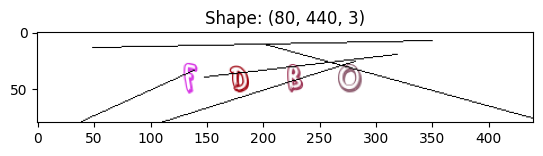

In [219]:
# show random image
img = cv2.imread(img_paths[np.random.randint(0, len(img_paths))])
plt.imshow(img)
plt.title(f'Shape: {img.shape}')
plt.show()

In [220]:
# Get list of ground-truth labels from image filenames
labels = [label_from_filepath(img_path) for img_path in img_paths]

# Get count of each unique char
char_counts = Counter(chain.from_iterable(labels))
            
# Sort by character
char_counts = sorted(char_counts.items())
# Convert items to two stand-alone lists
chars = [char_count[0] for char_count in char_counts]
counts = [char_count[1] for char_count in char_counts]
# Want first char on top, so reverse order
chars.reverse()
counts.reverse()

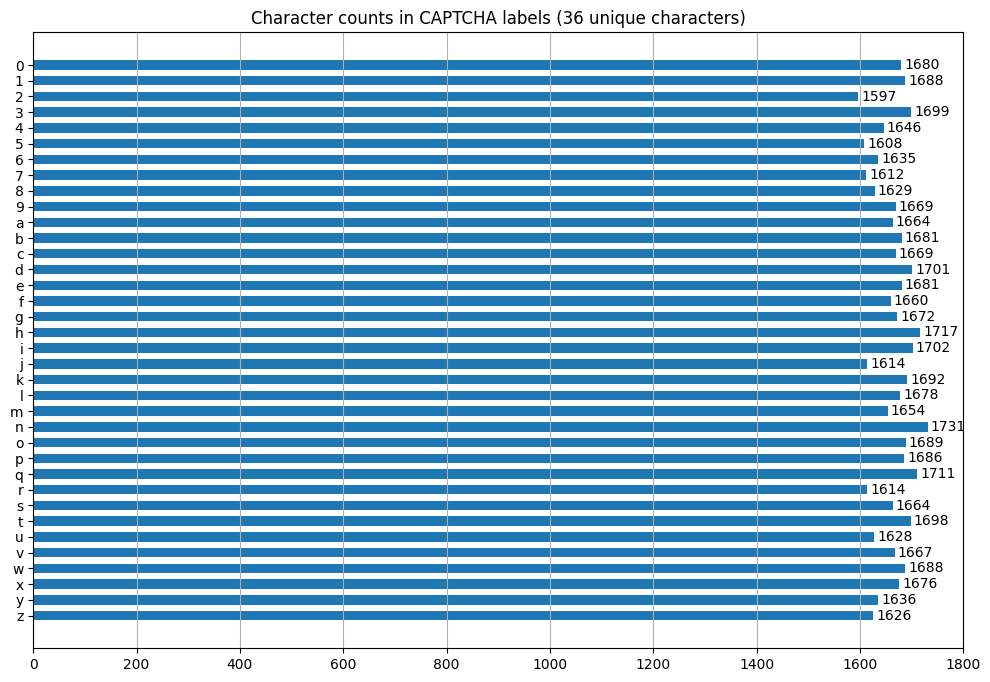

In [221]:
plt.figure(figsize=(12, 8))

bars = plt.barh(y=chars, width=counts, height=0.6)
for bar in bars:
    w = bar.get_width()
    y = bar.get_y()
    h = bar.get_height()
    plt.text(w+40, y+h/2, w, ha='center', va='center')
    
plt.xlim(0, 1800)
plt.grid(linestyle='-', axis='x')
plt.title(f'Character counts in CAPTCHA labels ({len(chars)} unique characters)')
plt.show()

In [222]:
import string

vocab = string.ascii_lowercase + string.digits
idx2char = {k:v for k,v in enumerate(vocab, start=0)}
char2idx = {v:k for k,v in idx2char.items()}
print("vocab size: ", len(vocab))
print(idx2char)
print(char2idx)

vocab size:  36
{0: 'a', 1: 'b', 2: 'c', 3: 'd', 4: 'e', 5: 'f', 6: 'g', 7: 'h', 8: 'i', 9: 'j', 10: 'k', 11: 'l', 12: 'm', 13: 'n', 14: 'o', 15: 'p', 16: 'q', 17: 'r', 18: 's', 19: 't', 20: 'u', 21: 'v', 22: 'w', 23: 'x', 24: 'y', 25: 'z', 26: '0', 27: '1', 28: '2', 29: '3', 30: '4', 31: '5', 32: '6', 33: '7', 34: '8', 35: '9'}
{'a': 0, 'b': 1, 'c': 2, 'd': 3, 'e': 4, 'f': 5, 'g': 6, 'h': 7, 'i': 8, 'j': 9, 'k': 10, 'l': 11, 'm': 12, 'n': 13, 'o': 14, 'p': 15, 'q': 16, 'r': 17, 's': 18, 't': 19, 'u': 20, 'v': 21, 'w': 22, 'x': 23, 'y': 24, 'z': 25, '0': 26, '1': 27, '2': 28, '3': 29, '4': 30, '5': 31, '6': 32, '7': 33, '8': 34, '9': 35}


# Characters Segmentation

In [223]:
train_dir = 'data/train' # Directory storing training images
test_dir = 'data/test' # Directory storing test images
train_data_dir = 'train' # Directory storing segmented images
test_data_dir = 'test' # Directory storing segmented images
os.makedirs(train_data_dir, exist_ok=True)
os.makedirs(test_data_dir, exist_ok=True)

In [224]:
def segment_chars(captcha_dir, save_dir):
    success = 0 # number of successful segmentations
    failures = [] # list of filenames with failed segmentations
    paths = [os.path.join(captcha_dir, f) for f in os.listdir(captcha_dir) if f.endswith('.png')]
    for file_path in tqdm(paths):
        filename = os.path.basename(file_path)
        label = filename.split('-')[0]
        objects = segmenter(file_path)
        if len(objects) == len(label):
            success += 1
            # save images with correct labels
            for i, obj in enumerate(objects):
                cv2.imwrite(f'{save_dir}/{label[i]}_{i}_{filename}', obj)
        else:
            failures.append(filename)

    print(f'Success: {success}, {success/len(paths)*100:.2f}%')
    return failures

In [225]:
# train_failures = segment_chars(train_dir, train_data_dir)
# with open('train_failed_images.txt', 'w') as f:
#     for filename in train_failures:
#         f.write(f'{filename}\n')

In [226]:
train_files = os.listdir(train_data_dir)
df = pd.DataFrame(train_files, columns=['filename'])
df['label'] = df['filename'].apply(lambda x: x.split('_')[0])
df.to_csv('train.csv', index=False)

In [227]:
# test_failures = segment_chars(test_dir, test_data_dir)
# with open('test_failed_images.txt', 'w') as f:
#     for filename in test_failures:
#         f.write(f'{filename}\n')

In [228]:
test_files = os.listdir(test_data_dir)
df = pd.DataFrame(test_files, columns=['filename'])
df['label'] = df['filename'].apply(lambda x: x.split('_')[0])
df.to_csv('test.csv', index=False)

# Create Dataset and Data Loaders

In [ ]:
transform = transforms.Compose([
    transforms.Grayscale(), # 3-band to 1-band
    transforms.Resize((28, 28)), # average size of each char image
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

In [230]:
class CharsDataset(Dataset):
    '''
    Custom PyTorch Dataset to load in individual character images segmented
    from CAPTCHA images
    '''
    def __init__(self, annotations_path, root_dir):
        self.annotations = pd.read_csv(annotations_path)
        self.root_dir = root_dir

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, index):
        img_path = os.path.join(self.root_dir, self.annotations.iloc[index, 0])
        img = Image.open(img_path)
        label = self.annotations.iloc[index, 1]
        y_label = torch.tensor(char2idx[label])
        img = transform(img)

        return (img, y_label)

In [231]:
train_set = CharsDataset('train.csv', train_data_dir)
test_set = CharsDataset('test.csv', test_data_dir)

In [232]:
len(train_set), len(test_set)

(41163, 10206)

Text(0.5, 1.0, 'Label: i')

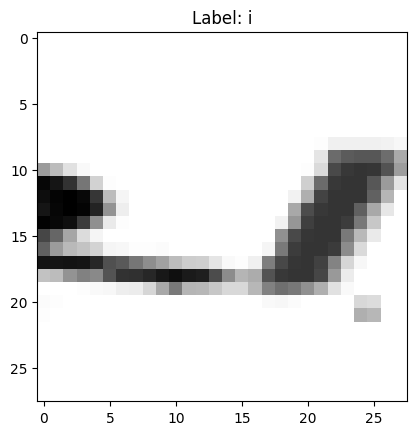

In [233]:
# show random image from train set
img, label = train_set[np.random.randint(0, len(train_set))]
img = img.squeeze().numpy()
plt.imshow(img, cmap='gray')
plt.title(f'Label: {idx2char[label.item()]}')

In [234]:
train_loader = DataLoader(dataset=train_set, batch_size=128, shuffle=True)
val_loader = DataLoader(dataset=test_set, batch_size=128, shuffle=True)

# CNN Model

In [235]:
import torch.nn.functional as F
class LeNet(nn.Module):
    '''
    Baseline LeNet-5 model for CAPTCHA character recognition.
    '''
    def __init__(self):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5, padding=2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1   = nn.Linear(16*5*5, 120)
        self.fc2   = nn.Linear(120, 84)
        self.fc3   = nn.Linear(84, 36)

    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv2(x)), (2, 2))
        x = x.view(-1, 16*5*5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [ ]:
class MyCNN(nn.Module):
    '''
    Custom CNN model for CAPTCHA character recognition.
    '''
    def __init__(self):
        super(MyCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5, padding=2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.conv3 = nn.Conv2d(16, 16, 3, padding=2)
        self.fc1   = nn.Linear(16 * 7 * 7, 120)
        self.fc2   = nn.Linear(120, 84)
        self.fc3   = nn.Linear(84, 36)

    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv2(x)), (2, 2))
        x = F.relu(self.conv3(x))
        x = x.view(-1, 16 * 7 * 7)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [ ]:
device = torch.device('cuda:3' if torch.cuda.is_available() else 'cpu')
model = LeNet().to(device)
# model = MyCNN().to(device)

# Train Model

In [239]:
optimizer = Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()
epochs = 5

In [240]:
for epoch in range(epochs):
    model.train()
    for batch_idx, (data, targets) in enumerate(train_loader):
        data = data.to(device)
        targets = targets.to(device)
        output = model(data)
        loss = criterion(output, targets)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch_idx % 200 == 0:
            print(f'epoch {epoch} batch {batch_idx} loss {loss.item()}')

    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for data, targets in val_loader:
            data = data.to(device)
            targets = targets.to(device)
            scores = model(data)
            _, predictions = scores.max(1)
            correct += (predictions == targets).sum()
            total += predictions.size(0)

        print(f'Test accuracy {correct/total}')

epoch 0 batch 0 loss 3.5898492336273193
epoch 0 batch 200 loss 1.4300200939178467
Test accuracy 0.6392318606376648
epoch 1 batch 0 loss 1.4445607662200928
epoch 1 batch 200 loss 0.9982801079750061
Test accuracy 0.699490487575531
epoch 2 batch 0 loss 1.0871394872665405
epoch 2 batch 200 loss 0.8945280313491821
Test accuracy 0.7410346865653992
epoch 3 batch 0 loss 0.872334361076355
epoch 3 batch 200 loss 0.8443821668624878
Test accuracy 0.7652361392974854
epoch 4 batch 0 loss 0.5837175250053406
epoch 4 batch 200 loss 0.6420710682868958
Test accuracy 0.7740544676780701


In [241]:
# Save state dictionary of trained model
torch.save(model.state_dict(), 'model_state_dict.pt')

# Evaluate Model

In [246]:
def predict(file_path, plot_segments=False):
    '''Use trained model to make a prediction on a CAPTCHA image'''
    # Segment CAPTCHA image into characters
    segmented_chars = segmenter(file_path)

    # Predict on each character
    predictions = []
    for x in segmented_chars:
        x = Image.fromarray(x) # to PIL image
        x = transform(x) # Apply Dataset transformations
        x = x.to(device)
        prediction = model(x.unsqueeze(0))
        y_hat = torch.max(prediction, 1)[1].data.squeeze()
        # Convert integer prediction to character using label dict
        y_hat = idx2char[y_hat.item()]
        predictions.append(y_hat)

    if plot_segments:
        _, axs = plt.subplots(1, len(segmented_chars), figsize=(15, 5))
        for i, ax in enumerate(axs):
            ax.imshow(segmented_chars[i])
            ax.set_title(f'Prediction: {predictions[i]}')
            ax.axis('off')
        plt.show()

        img = cv2.imread(file_path)
        plt.imshow(img)
        plt.title(f'Original Label: {label_from_filepath(file_path)}')
        plt.axis('off')
        plt.show()

    return "".join(predictions)

In [247]:
test_files = os.listdir('data/test')

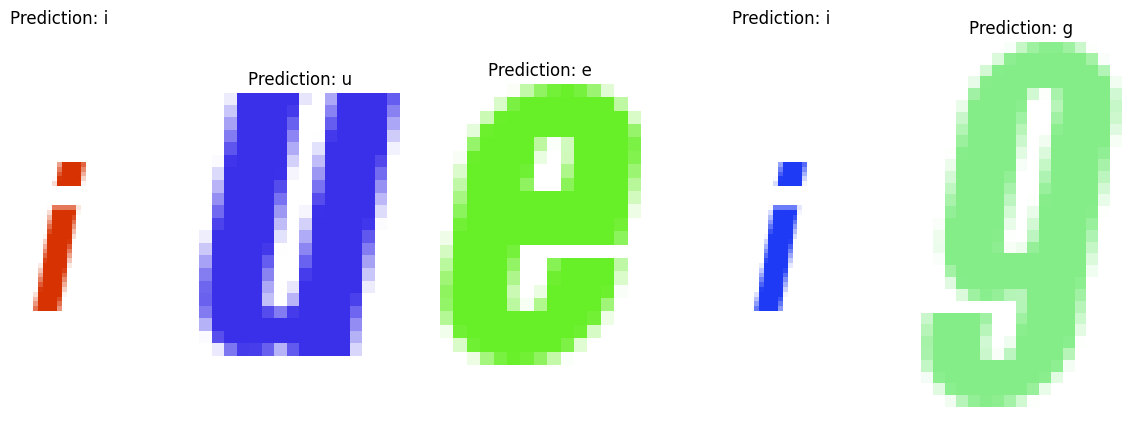

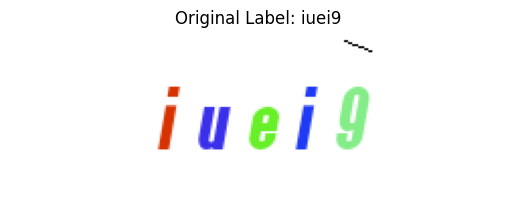

'iueig'

In [248]:
file = 'data/test/' + test_files[np.random.randint(0, len(test_files))]
predict(file, plot_segments=True)

In [249]:
correct = 0
for file in tqdm(test_files):
    pred = predict('data/test/' + file)
    if pred == label_from_filepath(file):
        correct += 1

print(f'Captcha Accuracy: {correct/len(test_files)*100:.2f}%')


100%|██████████| 2000/2000 [03:31<00:00,  9.45it/s]

Captcha Accuracy: 27.65%
